<a href="https://colab.research.google.com/github/EdH66/Colab_notebooks/blob/main/Multi_image_FineTuning_PyTorchandResNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multi-image augmentation and tuning Script with ResNet**

1.   Connect colab notebook to google drive






In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Inport libraries

In [ ]:
import torch
import torch .nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

import os

2. Setup transform functions for agumentation and normalisation of training and validation data sets. Convert to tensors. Now use Pytorch library not PIL ibrary

In [ ]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
}

3. Load data from google drive into the dataloaders (Train and Val) and print data size

In [ ]:
#Data path
data_dir = "/content/drive/My Drive/Colab Notebooks/Colab Classification/Data/Classification Dataset/"
#Load data
Datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                    data_transforms[x])
for x in ['Train', 'Val']}

#Define Train and Validation Dataloaders
dataloaders = {x:torch.utils.data.DataLoader(Datasets[x], batch_size=5,
                                             shuffle=True, num_workers=0)
for x in ['Train', 'Val']}

dataset_sizes = {x: len(Datasets[x]) for x in ['Train', 'Val']}
print(datasets_sizes)

class_names = Datasets['Val'].classes
print(class_names)


{'Train': 303, 'Val': 49}
['Bread', 'Coffee', 'Pasta']


4. Define a "device" variable for cuda to use GPU. Alternative CPU allowed.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

5. Define model training parameters

In [ ]:
def train_model(model, lossFunction, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model




6. Visualise the model using the imshow function

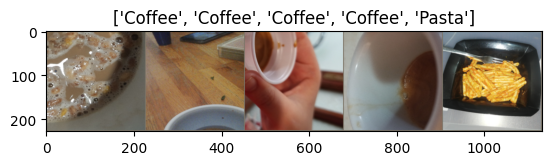

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            percentage = torch.sigmoid(outputs)[0] * 100
            _, indices = torch.sort(outputs, descending=True)
            probs=[percentage[idx].item() for idx in indices[0][:4]]

            classes=[class_names[idx] for idx in indices[0][:4]]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 5, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

7. Setup transfer learning by fine tuning

In [ ]:
import torchvision
from torchvision import models


*NB. Choose here if gradients are computed across the network by backpropagation using 'param.requires_grad = True' or stay fixed (fixed feature extraction) while only the last connected layer will be updated 'param.requires_grad = False' and select fixed feature extractor at the end. *

In [ ]:
#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
#Resnet101 = models.resnet101(weights=True)
#print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    param.requires_grad = True # to all gradients to be updated by backpropagation
    #param.requires_grad = False # to freeze all parameters so that gradients not computed by backpropagation

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(device)
#if using 'fixed feature extractor' to only train last fully connected layer use code below
#Resnet_featureExtractor = Resnet101.to(device)

8. Model hyperparameter optimisation setup

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
#Define optimisation algorithm for either fine tunning or fixed feature extraction
#optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00001) # lr = the learnnig rate decay after each epoch step size below
optimizer = optim.SGD(Resnet_featureExtractor.fc.parameters(), lr=0.00001) # lr = the learnnig rate decay after each epoch step size below

#Decay LR by a factor of 0.1 every 7 ephochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

9. Finetune the model (apply varaibles defined above).
10. Save the model to google drive

In [ ]:
%%time
#Time execution of model training
model_fineTuning = train_model(Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=20)
torch.save(model_fineTuning, "/content/drive/My Drive/Colab Notebooks/Colab Classification/Data/Models/Resnet_fineTuning.pth")
#model_featureExtractor = train_model(Resnet_featureExtractor, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=20)
#torch.save(model_featureExtractor, "/content/drive/My Drive/Colab Notebooks/Colab Classification/Data/Models/Resnet_featureExtractor.pth")

Epoch 0/19
----------
Train Loss: 0.3586 Acc: 0.8812
Val Loss: 0.1008 Acc: 0.9796

Epoch 1/19
----------
Train Loss: 0.2802 Acc: 0.9109
Val Loss: 0.0860 Acc: 0.9796

Epoch 2/19
----------
Train Loss: 0.2821 Acc: 0.9010
Val Loss: 0.1004 Acc: 0.9592

Epoch 3/19
----------
Train Loss: 0.2757 Acc: 0.9175
Val Loss: 0.2780 Acc: 0.9388

Epoch 4/19
----------
Train Loss: 0.2679 Acc: 0.9010
Val Loss: 0.5168 Acc: 0.9592

Epoch 5/19
----------
Train Loss: 0.3078 Acc: 0.8977
Val Loss: 0.0606 Acc: 1.0000

Epoch 6/19
----------
Train Loss: 0.2755 Acc: 0.9109
Val Loss: 0.1534 Acc: 0.9592

Epoch 7/19
----------
Train Loss: 0.2868 Acc: 0.8977
Val Loss: 0.2259 Acc: 0.9388

Epoch 8/19
----------
Train Loss: 0.3103 Acc: 0.9010
Val Loss: 0.2414 Acc: 0.9388

Epoch 9/19
----------
Train Loss: 0.3256 Acc: 0.8845
Val Loss: 0.0927 Acc: 0.9592

Epoch 10/19
----------
Train Loss: 0.3317 Acc: 0.8812
Val Loss: 0.3263 Acc: 0.9592

Epoch 11/19
----------
Train Loss: 0.2115 Acc: 0.9439
Val Loss: 0.3797 Acc: 0.9388

Ep

11. Load the saved model from google drive
12. Visualise the saved model

In [ ]:
Resnet_fineTuning = torch.load('/content/drive/My Drive/Colab Notebooks/Colab Classification/Data/Models/Resnet_fineTuning.pth')
#Resnet_featureExtractor = torch.load('/content/drive/My Drive/Colab Notebooks/Colab Classification/Data/Models/Resnet_featureExtractor.pth')

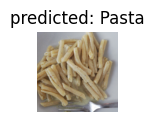

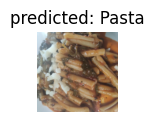

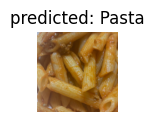

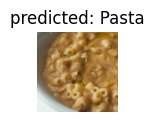

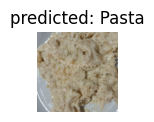

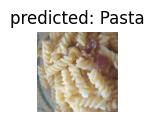

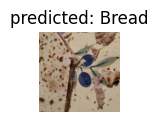

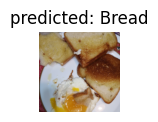

In [ ]:
visualize_model(Resnet_fineTuning)
#visualize_model(Resnet_featureExtractor)